<a href="https://colab.research.google.com/github/romeoVh/KFUPM_Teaching/blob/main/CIE483_Lecture_15_Grid_world_Model_based_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
**Ramy Rashad (KFUPM)**

**Resources**:
The following code has been adapted from the amazing tutorial series by Nan:
[Tutorial Series](https://medium.com/@ngao7/markov-decision-process-basics-3da5144d3348)
[Github Repo](https://github.com/clumsyhandyman/mad-from-scratch)


Welcome to this interactive tutorial on Model-Based Reinforcement Learning! In this lecture, we will focus on implementing two important techniques: the Monte Carlo (MC) approach and the Policy Iteration algorithm, applied to a classic Grid World Markov Decision Process (MDP).

In reinforcement learning, an agent interacts with an environment, learning how to make decisions that maximize some notion of long-term reward. Model-based reinforcement learning refers to techniques where the agent has access to the model of the environment's dynamics and reward function.

What you will learn:
Monte Carlo Approach: We will use the Monte Carlo method to evaluate the value function of states, allowing us to estimate the long-term rewards based on repeated sampling of the environment.

Policy Iteration Algorithm: You'll implement the policy iteration algorithm, a powerful method that alternates between evaluating a policy and improving it until convergence. By the end, you'll see how this algorithm can find the optimal policy in a Grid World MDP.

# The Grid World MDP
Our environment will be a simple Grid World, where the agent navigates on a 2D grid to reach a goal while avoiding obstacles. This provides a perfect framework for visualizing how our reinforcement learning algorithms work in practice.

By the end of this tutorial, you will gain hands-on experience with key model-based RL techniques and deepen your understanding of how Monte Carlo methods and policy iteration can be used to solve MDPs.

Let’s get started!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import time
import pandas as pd


class GridWorld:
    def __init__(self, map, reward, random_rate=0.2, time_limit=1000):
        self.map = map
        self.num_rows = self.map.shape[0]
        self.num_cols = self.map.shape[1]
        self.num_states = self.num_rows * self.num_cols
        self.num_actions = 4
        self.reward = reward
        self.random_rate = random_rate
        self.time_limit = time_limit
        self.reward_function = self.get_reward_function()
        self.transition_model = self.get_transition_model()
        self.wall_indices = self.get_wall_indices()
        self.t_states_indices = self.get_t_states_indices()


    def get_state_from_pos(self, pos):
        return pos[0] * self.num_cols + pos[1]

    def get_pos_from_state(self, state):
        return state // self.num_cols, state % self.num_cols

    def get_wall_indices(self):
        indices = []
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                if self.map[r, c] == 3:
                    indices.append(self.get_state_from_pos((r, c)))
        return indices

    def get_t_states_indices(self):
        indices = []
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                if self.map[r, c] == 1 or self.map[r, c] == 2:
                    indices.append(self.get_state_from_pos((r, c)))
        return indices

    def get_reward_function(self):
        reward_table = np.zeros(self.num_states)
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state_from_pos((r, c))
                reward_table[s] = self.reward[self.map[r, c]]
        return reward_table

    def get_transition_model(self):
        transition_model = np.zeros((self.num_states, self.num_actions, self.num_states))
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state_from_pos((r, c))
                neighbor_s = np.zeros(self.num_actions)
                if self.map[r, c] == 0:
                    for a in range(self.num_actions):
                        new_r, new_c = r, c
                        if a == 0:
                            new_r = max(r - 1, 0)
                        elif a == 1:
                            new_c = min(c + 1, self.num_cols - 1)
                        elif a == 2:
                            new_r = min(r + 1, self.num_rows - 1)
                        elif a == 3:
                            new_c = max(c - 1, 0)
                        if self.map[new_r, new_c] == 3:
                            new_r, new_c = r, c
                        s_prime = self.get_state_from_pos((new_r, new_c))
                        neighbor_s[a] = s_prime
                else:
                    neighbor_s = np.ones(self.num_actions) * s
                for a in range(self.num_actions):
                    transition_model[s, a, int(neighbor_s[a])] += 1 - self.random_rate
                    transition_model[s, a, int(neighbor_s[(a + 1) % self.num_actions])] += self.random_rate / 2.0
                    transition_model[s, a, int(neighbor_s[(a - 1) % self.num_actions])] += self.random_rate / 2.0
        return transition_model

    def generate_random_policy(self):
        return np.random.randint(self.num_actions, size=self.num_states)

    def execute_policy(self, policy, start_pos, gamma = 1):
        s = self.get_state_from_pos(start_pos)
        r = self.reward_function[s]
        total_reward = 0
        episode = [s]

        start_time = int(round(time() * 1000))
        overtime = False

        if r==self.reward[3]:
            return total_reward, episode

        if r==self.reward[1] or r==self.reward[2]:
            return r, episode

        k = 0
        while r != self.reward[1] and r != self.reward[2]:
            s = np.random.choice(self.num_states, p=self.transition_model[s, policy[s]])
            episode.append(s)
            r = self.reward_function[s]
            total_reward += pow(gamma,k)*r
            k += 1
            cur_time = int(round(time() * 1000)) - start_time
            if cur_time > self.time_limit:
                overtime = True
                break
        if overtime is True:
            return float('-inf'), episode
        else:
            return total_reward, episode


    def get_policy_transition(self,policy):
        P_pi = np.zeros((self.num_states,self.num_states))
        for s in range(self.num_states):
            P_pi[s,:] = self.transition_model[s,policy[s],:]
        return P_pi


    def random_start_policy(self, policy, start_pos, n=100, plot=True):
        start_time = int(round(time() * 1000))
        overtime = False
        scores = np.zeros(n)
        i = 0
        while i < n:
            temp = self.execute_policy(policy=policy, start_pos=start_pos)
            print(f'i = {i} Random start result: {temp}')
            if temp > float('-inf'):
                scores[i] = temp
                i += 1
            cur_time = int(round(time() * 1000)) - start_time
            if cur_time > n * self.time_limit:
                overtime = True
                break

        print(f'max = {np.max(scores)}')
        print(f'min = {np.min(scores)}')
        print(f'mean = {np.mean(scores)}')
        print(f'std = {np.std(scores)}')

        if overtime is False and plot is True:
            bins = 100
            fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
            ax.set_xlabel('Total rewards in a single game')
            ax.set_ylabel('Frequency')
            ax.hist(scores, bins=bins, color='#1f77b4', edgecolor='black')
            plt.show()

        if overtime is True:
            print('Overtime!')
            return None
        else:
            return np.max(scores), np.min(scores), np.mean(scores)

    def blackbox_move(self, s, a):
        temp = self.transition_model[s, a]
        s_prime = np.random.choice(self.num_states, p=temp)
        r = self.reward_function[s_prime]
        return s_prime, r

    def plot_map(self, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')
        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)

        plt.tight_layout()
        plt.show()

    def plot_policy(self, policy, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')
        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                s = self.get_state_from_pos((i, j))
                if self.map[i, j] == 0:
                    a = policy[s]
                    symbol = ['^', '>', 'v', '<']
                    ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=symbol[a],
                            linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')

        plt.tight_layout()
        plt.show()

    def visualize_value_policy(self, policy, values, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')

        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                s = self.get_state_from_pos((i, j))
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                if self.map[i, j] != 3:
                    ax.text(x + 0.5 * unit, y + 0.5 * unit, f'{values[s]:.4f}',
                            horizontalalignment='center', verticalalignment='center',
                            fontsize=max(fig_size)*unit*0.6)
                if policy is not None:
                    if self.map[i, j] == 0:
                        a = policy[s]
                        symbol = ['^', '>', 'v', '<']
                        ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=symbol[a], alpha=0.4,
                                linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')

        plt.tight_layout()
        plt.show()

# Creating our Grid world

In this section, we will visualize the Grid World environment and explore its dynamics. The grid map is defined as a 3x4 grid where different cells represent distinct states:

- 0: Regular cells with a small penalty for movement (-0.04 reward).
- 1: A goal state with a positive reward (+1.0).
- 2: A state with a negative reward (-1.0), which we want to avoid.
- 3: An obstacle (NaN), where the agent cannot enter.

We'll also examine the transition model of the environment, which shows the probabilities of moving from one state to another based on the chosen action (up, right, down, left).

Finally, we'll initialize a sample policy to show the agent’s movement direction in each state. The policy here is a sequence of actions assigned to each state, represented as arrows.



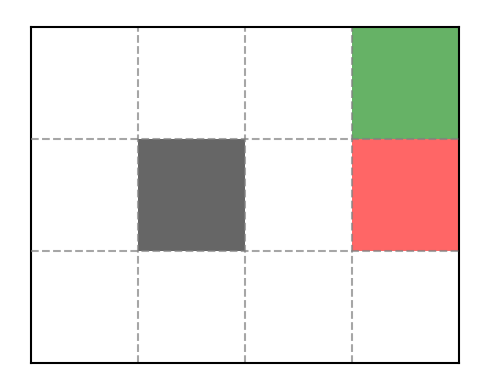

P(s'|s,a=U) =
     s_a  s_b  s_c  s_d  s_e  s_x  s_f  s_g  s_h  s_i  s_j  s_k
s_a  0.9  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_b  0.1  0.8  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_c  0.0  0.1  0.8  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_d  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_e  0.8  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_x  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
s_f  0.0  0.0  0.8  0.0  0.0  0.0  0.1  0.1  0.0  0.0  0.0  0.0
s_g  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
s_h  0.0  0.0  0.0  0.0  0.8  0.0  0.0  0.0  0.1  0.1  0.0  0.0
s_i  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.8  0.1  0.0
s_j  0.0  0.0  0.0  0.0  0.0  0.0  0.8  0.0  0.0  0.1  0.0  0.1
s_k  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.8  0.0  0.0  0.1  0.1
----------------------------------------------------------------------
P(s'|s,a=R) =
     s_a  s_b  s_c  s_d  s_e  s_x  s_f  s_g  s_h  s_i  s_j  s_k
s_a  

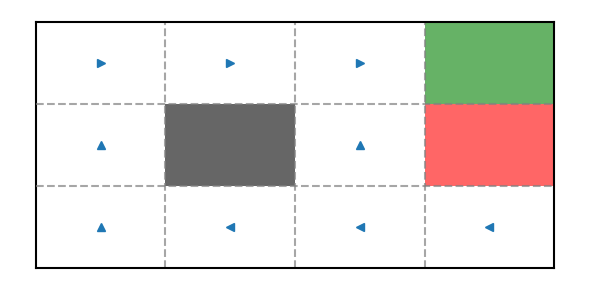

In [ ]:
grid_map = np.array([[0,0,0,1],[0,3,0,2],[0,0,0,0]])
problem = GridWorld(grid_map, reward={0: -0.04, 1: 1.0, 2: -1.0, 3: np.NaN})
problem.plot_map(fig_size=(5, 4))

s_map = ['s_a','s_b','s_c','s_d','s_e','s_x','s_f','s_g','s_h','s_i','s_j','s_k']
a_map = ['U','R','D','L']

transition_model = problem.transition_model
for a in range(problem.num_actions):
    print(f'P(s\'|s,a={a_map[a]}) =')
    df = pd.DataFrame(transition_model[:,a,:], columns=s_map, index=s_map)
    print(df)
    print('----------------------------------------------------------------------')

#init_policy = problem.generate_random_policy()
pi_1 = ['R','R','R','D','U','D','U','D','U','L','L','L']
pi_1 = np.array([a_map.index(i) for i in pi_1])
problem.plot_policy(pi_1, fig_size=(6, 3))

## Executing $\pi_1$ and Evaluating Returns

In this part of the tutorial, we will simulate multiple episodes of the agent following a predefined policy in the Grid World environment. Specifically, we’ll execute the policy $\pi_1$ starting from the initial state $s_h$, i.e., cell $(2, 0)$ over N episodes.

For each episode, we compute the total return $(G)$, which represents the cumulative reward the agent collects over time.
We also record the sequence of states (episode) the agent visits during each run.
By running the simulation $N = 10$ times, we’ll analyze the average and standard deviation of the returns, helping us understand the variability in the agent's performance. The output also shows the exact path the agent follows in each episode, mapping the states back to their corresponding labels.



In [ ]:
N = 10
G_arr = []
episode_arr = []
for i in range(N):
    G, episode = problem.execute_policy(pi_1, (2,0),gamma = 1)
    G_arr.append(G)
    episode_arr.append(episode)
print(f'N = {N}, G_mean = {np.mean(G_arr)}, G_std = {np.std(G_arr)}')

for i in range(N):
    print(f'G = {G_arr[i]}, Episode = {[s_map[s] for s in episode_arr[i]]}')


N = 10, G_mean = 0.836, G_std = 0.011999999999999976
G = 0.84, Episode = ['s_h', 's_e', 's_a', 's_b', 's_c', 's_d']
G = 0.84, Episode = ['s_h', 's_e', 's_a', 's_b', 's_c', 's_d']
G = 0.84, Episode = ['s_h', 's_e', 's_a', 's_b', 's_c', 's_d']
G = 0.84, Episode = ['s_h', 's_e', 's_a', 's_b', 's_c', 's_d']
G = 0.84, Episode = ['s_h', 's_e', 's_a', 's_b', 's_c', 's_d']
G = 0.84, Episode = ['s_h', 's_e', 's_a', 's_b', 's_c', 's_d']
G = 0.84, Episode = ['s_h', 's_e', 's_a', 's_b', 's_c', 's_d']
G = 0.8, Episode = ['s_h', 's_e', 's_a', 's_b', 's_c', 's_c', 's_d']
G = 0.84, Episode = ['s_h', 's_e', 's_a', 's_b', 's_c', 's_d']
G = 0.84, Episode = ['s_h', 's_e', 's_a', 's_b', 's_c', 's_d']


# Estimating the State Value Function $v_{\pi_1}$:
## 1. Using Monte Carlo Simulation
In this section, we’ll estimate the value function $v_{\pi_1}(s)$ for each state under the policy \pi_1 using Monte Carlo sampling. The value function

We set $N=10,000$ meaning we’ll execute the policy from each state in the Grid World 10,000 times to compute an accurate estimate of the average return.
After running the simulations for each state, we compute the average return G and use this as the estimated value of the state.
This process gives us a Monte Carlo estimate of the value function for all states, which is printed in a 1x12 array corresponding to the Grid World layout. This estimation will help us understand how valuable each state is under the current policy.



s = s_a
s = s_b
s = s_c
s = s_d
s = s_e
s = s_f
s = s_g
s = s_h
s = s_i
s = s_j
s = s_k


<ipython-input-12-a589d51c2c41>:301: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


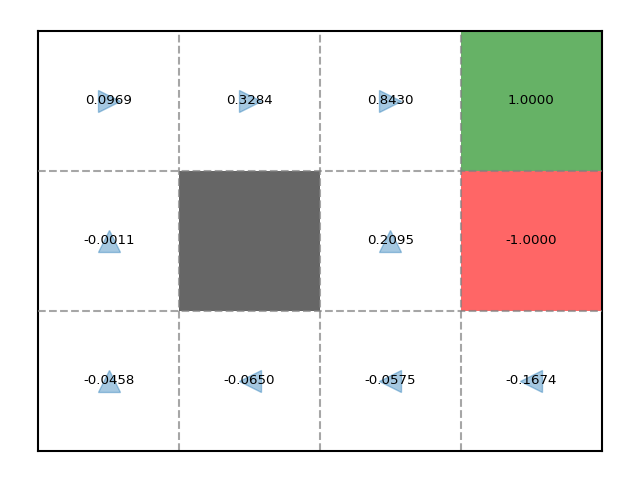

In [ ]:
N = 10000
v_pi = np.zeros(problem.num_states)

for r in range(problem.num_rows):
    for c in range(problem.num_cols):
      if problem.map[r,c] == 3:
        continue
      print(f's = {s_map[problem.get_state_from_pos((r,c))]}')
      G_arr = []
      episode_arr = []
      for i in range(N):
          G, episode = problem.execute_policy(pi_1, (r,c),gamma = 0.5)
          G_arr.append(G)
          episode_arr.append(episode)
      v_pi[problem.get_state_from_pos((r,c))] = np.mean(G_arr)

problem.visualize_value_policy(policy=pi_1, values=v_pi)

### Supplementary: Assignment 3

In this section you'll find some code snippets that provide the solution to Assignment 3

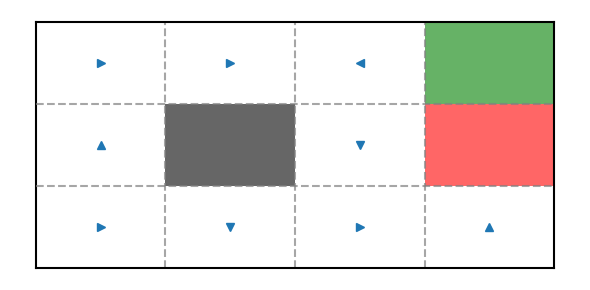

     s_a  s_b  s_c  s_d  s_e  s_x  s_f  s_g  s_h  s_i  s_j  s_k
s_a  0.1  0.8  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_b  0.0  0.2  0.8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_c  0.0  0.8  0.1  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0
s_d  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_e  0.8  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_x  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
s_f  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.1  0.0  0.0  0.8  0.0
s_g  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
s_h  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.1  0.8  0.0  0.0
s_i  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.8  0.1  0.0
s_j  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.1  0.8
s_k  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.8  0.0  0.0  0.1  0.1
----------------------------------------------------------------------


In [ ]:
grid_map = np.array([[0,0,0,1],[0,3,0,2],[0,0,0,0]])

problem = GridWorld(grid_map, reward={0: -0.04, 1: 1.0, 2: -1.0, 3: np.NaN})
s_map = ['s_a','s_b','s_c','s_d','s_e','s_x','s_f','s_g','s_h','s_i','s_j','s_k']
a_map = ['U','R','D','L']
pi_4 = ['R','R','L','D','U','D','D','D','R','D','R','U']
pi_4 = np.array([a_map.index(i) for i in pi_4])
problem.plot_policy(pi_4, fig_size=(6, 3))
P_pi_4 = problem.get_policy_transition(pi_4)
df = pd.DataFrame(P_pi_4, columns=s_map, index=s_map)
print(df)
print('----------------------------------------------------------------------')

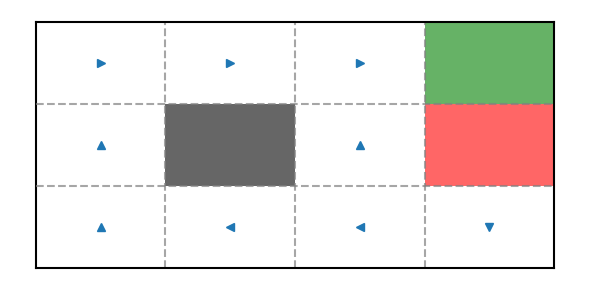

     s_a  s_b  s_c  s_d  s_e  s_x  s_f  s_g  s_h  s_i  s_j  s_k
s_a  0.1  0.8  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_b  0.0  0.2  0.8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_c  0.0  0.0  0.1  0.8  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0
s_d  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_e  0.8  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0
s_x  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
s_f  0.0  0.0  0.8  0.0  0.0  0.0  0.1  0.1  0.0  0.0  0.0  0.0
s_g  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
s_h  0.0  0.0  0.0  0.0  0.8  0.0  0.0  0.0  0.1  0.1  0.0  0.0
s_i  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.8  0.2  0.0  0.0
s_j  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.8  0.1  0.0
s_k  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.9
----------------------------------------------------------------------


In [ ]:
pi_3 = ['R','R','R','D','U','D','U','D','U','L','L','D']
pi_3 = np.array([a_map.index(i) for i in pi_3])
problem.plot_policy(pi_3, fig_size=(6, 3))
P_pi_3 = problem.get_policy_transition(pi_3)
df = pd.DataFrame(P_pi_3, columns=s_map, index=s_map)
print(df)
print('----------------------------------------------------------------------')

In [ ]:
N = 20
G_arr = []
episode_arr = []
for i in range(N):
    G, episode = problem.execute_policy(pi_3, (2,3),gamma = 0.5)
    G_arr.append(G)
    episode_arr.append(episode)
print(f'N = {N}, G_mean = {np.mean(G_arr)}, G_std = {np.std(G_arr)}')

for i in range(N):
    print(f'G = {G_arr[i]}, Episode = {[s_map[s] for s in episode_arr[i]]}')


N = 20, G_mean = -0.07788377163706173, G_std = 0.0073235531788062485
G = -0.07999999899417161, Episode = ['s_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_j', 's_i', 's_i', 's_h', 's_e', 's_a', 's_b', 's_b', 's_c', 's_d']
G = -0.0798681640625, Episode = ['s_k', 's_j', 's_i', 's_h', 's_e', 's_e', 's_e', 's_a', 's_e', 's_e', 's_a', 's_b', 's_b', 's_c', 's_d']
G = -0.07999998390674591, Episode = ['s_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_j', 's_i', 's_h', 's_e', 's_a', 's_b', 's_c', 's_d']
G = -0.07999794006347656, Episode = ['s_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_j', 's_i', 's_h', 's_i', 's_h', 's_e', 's_e', 's_a', 's_b', 's_b', 's_c', 's_d']
G = -0.07999897003173828, Episode = ['s_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', 's_k', '

## 2. Using Bellman's equation via Matrix Inversion
n this section, we take a more direct approach to calculating the value function $v_{\pi_1}$ by solving the Bellman equations algebraically. Instead of using Monte Carlo simulations, we will leverage linear algebra to compute the value function for the given policy $\pi_1$.

Here’s a breakdown of what the code does:

- Transition Matrix $P_{\pi_1}$:

We first retrieve the transition matrix for the policy $\pi_1$, which gives the probability of moving from one state to another under the current policy.

- Reward Vector $R_{\pi_1}$:

We compute the reward function for each current state from the original reward function dependent on the next state, with some adjustments for wall states (obstacles) where the agent cannot transition.

- Bellman Equation Setup:

The matrix form of the Bellman equation is set up as:

$(I - \gamma P_{\pi_1}) v_{\pi_1} = R_{\pi_1}$

where $I$ is the identity matrix and $\gamma$ is the discount factor (set to 0.5).

We solve this equation using matrix inversion.

This gives the exact value function for all states under policy pi_1.

- Visualization:

Finally, we visualize the resulting value function and policy to see how well the agent is expected to perform in each state based on the given policy.

**This method is much faster and more accurate than Monte Carlo sampling for small state spaces, as we’re directly solving for the values rather than relying on simulation. However, the Monte Carlo simulation is more general because it is applicable to problems that do not have an MDP structure.**

Time taken: 0.00026607513427734375


<ipython-input-12-a589d51c2c41>:301: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


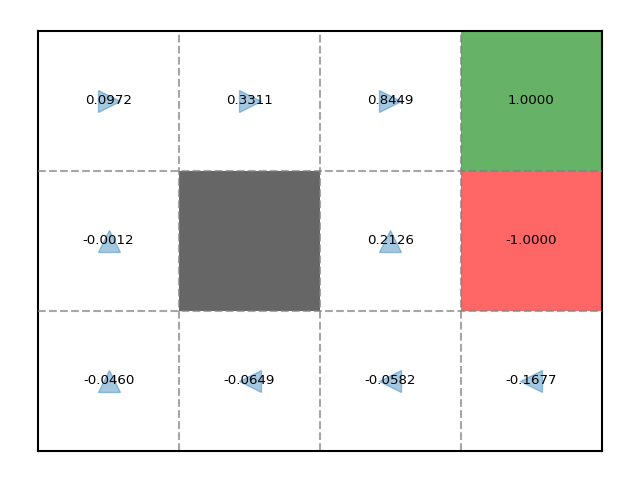

In [ ]:
gamma = 0.5
P_pi_1 = problem.get_policy_transition(pi_1)
R_1 = problem.reward_function

for ind in problem.wall_indices:
    R_1[ind] = 0
for ind in problem.wall_indices:
    P_pi_1[ind,ind] = 0

R_E_1 = np.dot(P_pi_1,R_1)
#print(b)

for ind in problem.t_states_indices:
    P_pi_1[:,ind] = np.zeros(problem.num_states)

#df = pd.DataFrame(P_pi_1, columns=s_map, index=s_map)
#print(df)
#print(b)

A = np.eye(problem.num_states)-gamma*P_pi_1
df = pd.DataFrame(A, columns=s_map, index=s_map)
#print(df)

t_start = time()
v_pi_1_BM = np.dot(np.linalg.inv(A), R_E_1)
#v_pi_1_BM = np.linalg.solve(A,R_E_1)

t_end = time()
print(f'Time taken: {t_end-t_start}')
#print(v_pi_1_BM)

problem.visualize_value_policy(policy=pi_1, values=v_pi_1_BM)



## 3. Using Iterative Policy Evaluation

In this section, we implement the Iterative Policy Evaluation algorithm, which allows us to estimate the value function for a given policy. This method is based on Bellman's optimality equation and iteratively updates the value function until it converges within a specified tolerance.

Key Concepts:
Value Function: The goal is to compute the expected return for each state under the current policy. The value function estimates how good it is for the agent to be in a particular state, based on future rewards.

Bellman Update: The value of each state
V(s) is updated using the Bellman equation:

$V(s)=R(s)+γ \sum_{s'} P(s′∣s,π(s))V(s′)$

where where $R(s)$ is the expected immediate reward for being in state $s$.

Execution:
The method iterative_policy_evaluation() iteratively updates the value function for all states based on the current policy, using the reward vector R and transition matrix P.
The process is repeated until the value function stabilizes within a small tolerance
ϵ=1e−5.
Finally, the computed value function is visualized to show how well the agent performs in each state under the given policy.



Time taken: 0.0014832019805908203


<ipython-input-12-a589d51c2c41>:301: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


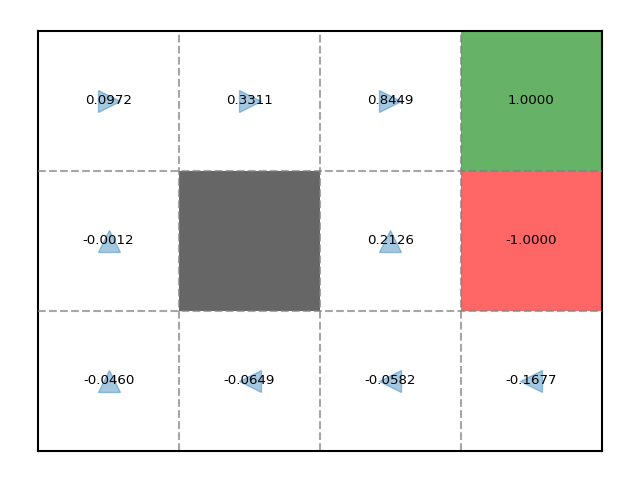

In [ ]:
def iterative_policy_evaluation(R, P, gamma=0.9, epsilon=1e-5):
    """
    Perform iterative policy evaluation.

    :param policy: The policy being evaluated (list of actions for each state).
    :param states: The list of states in the MDP.
    :param gamma: Discount factor.
    :param epsilon: A small threshold for convergence.
    :return: The estimated value function.
    """
    V = np.zeros(len(R))  # Initialize the value function

    while True:
        delta = 0  # Initialize the maximum change in value
        for s in range(len(R)):
            v = V[s]  # Save the current value
            # Update value function using Bellman's equation
            V[s] = R[s] + gamma*np.dot(P[s,:], V)
            delta = max(delta, abs(v - V[s]))  # Calculate the change
        if delta < epsilon:  # Check for convergence
            break
    return V

t_start = time()
v_pi_1_IPE = iterative_policy_evaluation(R_E_1,P_pi_1,gamma=gamma)
t_end = time()
print(f'Time taken: {t_end-t_start}')
#print(v_pi_1_IPE)
problem.visualize_value_policy(policy=pi_1, values=v_pi_1_IPE)


# Model-based RL: Policy Iteration
## Implementing Policy Iteration

In this section, we define the **Policy Iteration algorithm** for solving Markov Decision Processes (MDPs). Policy Iteration is a dynamic programming method that alternates between two key steps: **policy evaluation** and **policy improvement**, iteratively refining the policy until it converges to the optimal solution.

**Key Components:**

- **Initialization**: The PolicyIteration class initializes with a random policy (if no policy is provided) and a value function initialized to zeros. The transition dynamics and reward structure of the environment are also passed to the class.

- **Policy Evaluation**: The method one_policy_evaluation() computes the value function for the current policy by solving the Bellman equations iteratively. The values are updated based on the current policy’s transition matrix and rewards until the change in values is smaller than a specified tolerance.

- **Policy Improvement**:The method run_policy_improvement() updates the policy by selecting the action that maximizes the expected value for each state, based on the current value estimates. If the policy doesn't change, the algorithm has converged.

- **Training**: The train() method runs the complete Policy Iteration process, alternating between policy evaluation and improvement until the policy stabilizes. It also tracks the number of sweeps required during policy evaluation and the number of policy updates at each iteration.

- **Debugging and Visualization**: If the debug mode is enabled, the value function and policy are visualized at each step, providing insights into the agent’s behavior and learning progress.

By implementing this class, you will get a deeper understanding of how Policy Iteration converges to the optimal policy for a given MDP, and how the value function evolves during the process.



In [ ]:
class PolicyIteration:
    def __init__(self, problem, gamma, init_policy=None,debug=False):
        self.debug = debug
        self.problem = problem
        self.transition_model = problem.transition_model
        self.reward_function = np.nan_to_num(problem.reward_function)
        self.num_states = self.transition_model.shape[0]
        self.num_actions = self.transition_model.shape[1]

        self.gamma = gamma

        self.values = np.zeros(self.num_states)
        if init_policy is None:
            self.policy = np.random.randint(0, self.num_actions, self.num_states)
        else:
            self.policy = init_policy
        if self.debug is True:
          problem.visualize_value_policy(policy=self.policy, values=self.values)


    def one_policy_evaluation(self):
        P = self.problem.get_policy_transition(self.policy)
        R = problem.reward_function

        for ind in problem.wall_indices:
            R[ind] = 0
        for ind in problem.wall_indices:
            P[ind,ind] = 0

        R = np.dot(P,R)

        for ind in problem.t_states_indices:
            P[:,ind] = np.zeros(self.num_states)

        delta = 0
        for s in range(self.num_states):
            temp = self.values[s]
            self.values[s] = R[s] + gamma*np.dot(P[s,:], self.values)

            delta = max(delta, abs(temp - self.values[s]))
        return delta

    def run_policy_evaluation(self, tol=1e-3):
        epoch = 0
        delta = self.one_policy_evaluation()
        delta_history = [delta]
        while epoch < 500:
            delta = self.one_policy_evaluation()
            delta_history.append(delta)
            if delta < tol:
                break
        return len(delta_history)

    def run_policy_improvement(self):
        update_policy_count = 0
        for s in range(self.num_states):
            temp = self.policy[s]
            v_list = np.zeros(self.num_actions)
            for a in range(self.num_actions):
                p = self.transition_model[s, a]
                v_list[a] = np.sum(p*self.values)
                # Note that because R(s) and γ are independent of the action, they do not affect the function argmax
            self.policy[s] = np.argmax(v_list)
            if temp != self.policy[s]:
                update_policy_count += 1
        return update_policy_count

    def train(self, tol=1e-3, plot=True):
        epoch = 0
        eval_count = self.run_policy_evaluation(tol=tol)
        eval_count_history = [eval_count]
        if self.debug is True:
          self.problem.visualize_value_policy(policy=self.policy, values=self.values)

        policy_change = self.run_policy_improvement()
        policy_change_history = [policy_change]
        if self.debug is True:
          self.problem.visualize_value_policy(policy=self.policy, values=self.values)

        while epoch < 500:
            epoch += 1
            new_eval_count = self.run_policy_evaluation(tol)
            if self.debug is True:
              self.problem.visualize_value_policy(policy=self.policy, values=self.values)

            new_policy_change = self.run_policy_improvement()
            if self.debug is True:
              self.problem.visualize_value_policy(policy=self.policy, values=self.values)

            eval_count_history.append(new_eval_count)
            policy_change_history.append(new_policy_change)
            if new_policy_change == 0:
                break

        print(f'# epoch: {len(policy_change_history)}')
        print(f'eval count = {eval_count_history}')
        print(f'policy change = {policy_change_history}')

        if plot is True:
            fig, axes = plt.subplots(2, 1, figsize=(3.5, 4), sharex='all', dpi=200)
            axes[0].plot(np.arange(len(eval_count_history)), eval_count_history, marker='o', markersize=4, alpha=0.7,
                         color='#2ca02c', label='# sweep in \npolicy evaluation\n' + r'$\gamma =$' + f'{self.gamma}')
            axes[0].legend()

            axes[1].plot(np.arange(len(policy_change_history)), policy_change_history, marker='o',
                         markersize=4, alpha=0.7, color='#d62728',
                         label='# policy updates in \npolicy improvement\n' + r'$\gamma =$' + f'{self.gamma}')
            axes[1].set_xlabel('Epoch')
            axes[1].legend()
            plt.tight_layout()
            plt.show()


## Running Policy Iteration

In this step, we initialize and run the Policy Iteration algorithm on the Grid World environment.

- **PolicyIteration Class**: We create an instance of the PolicyIteration class, which will handle the process of alternating between policy evaluation and policy improvement to find the optimal policy for the given environment. The discount factor γ is set to 0.9, and debugging is enabled to visualize the value and policy updates at each step.

- **Training**: The train() method runs the Policy Iteration algorithm, repeatedly evaluating and improving the policy until it converges. We disable plotting here, but the process tracks how the policy evolves and how quickly the value function stabilizes.

By running this snippet, the algorithm will compute the optimal policy for navigating the Grid World environment.



<ipython-input-12-a589d51c2c41>:301: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


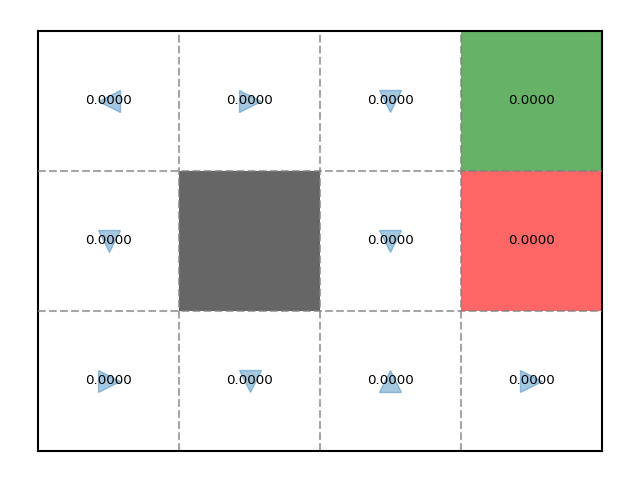

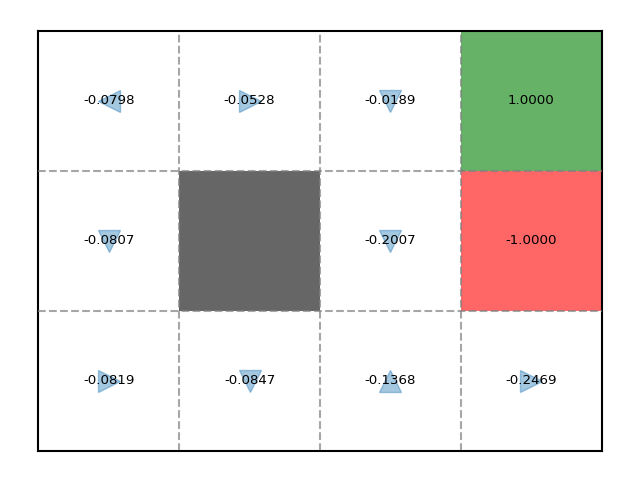

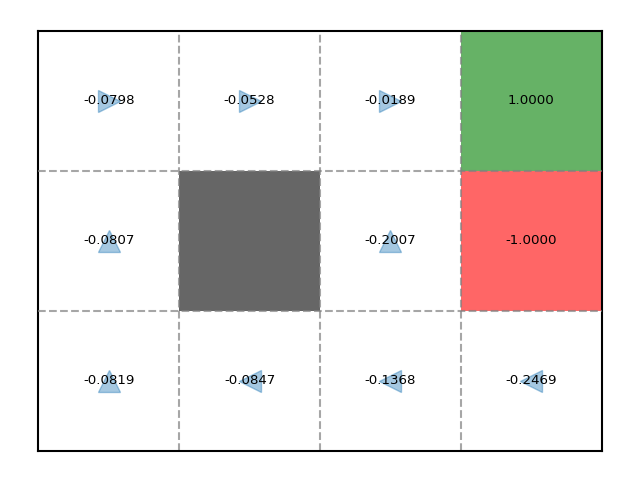

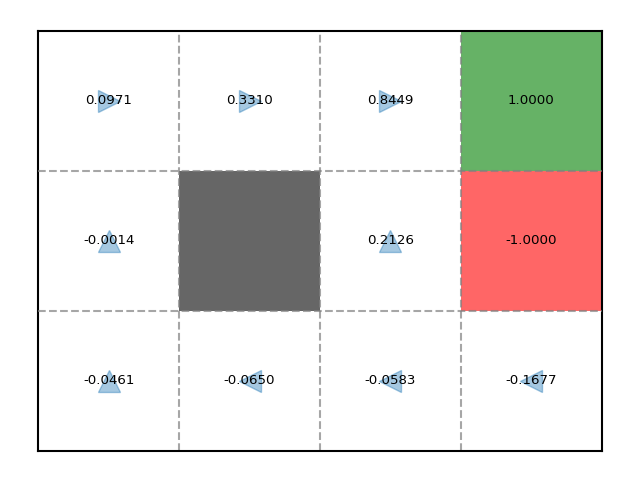

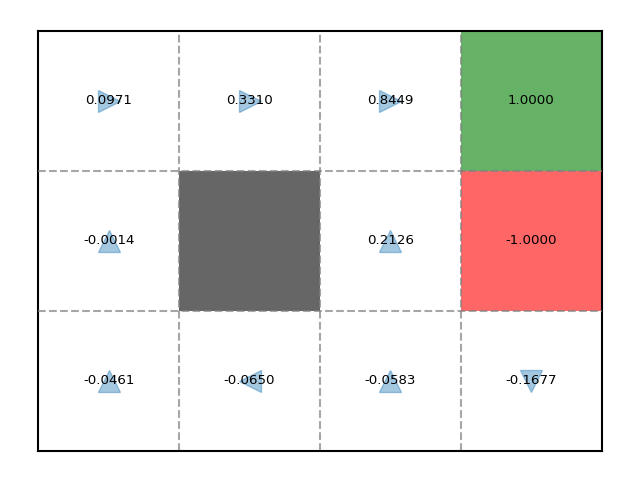

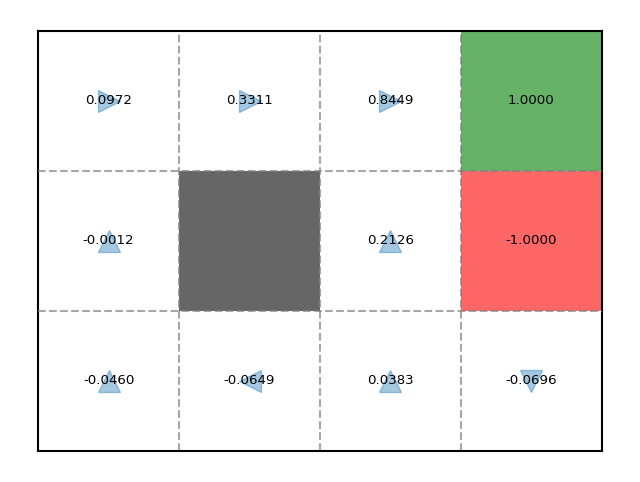

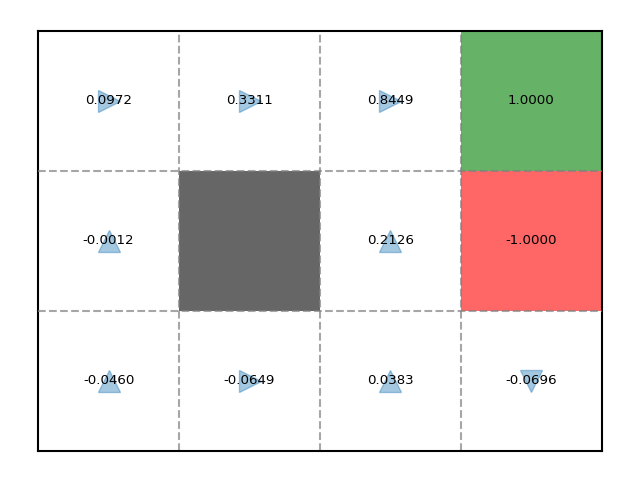

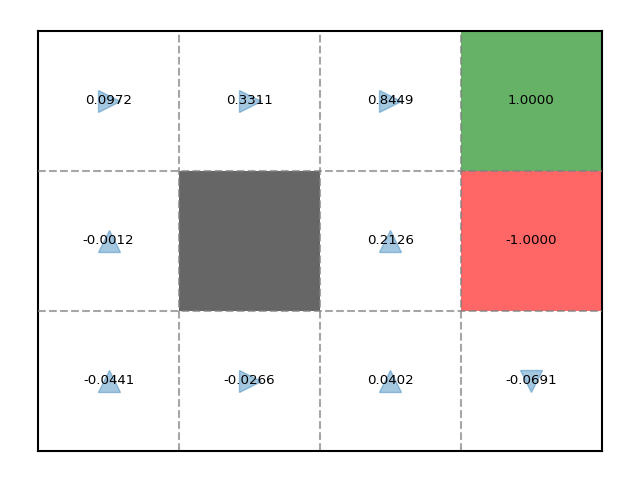

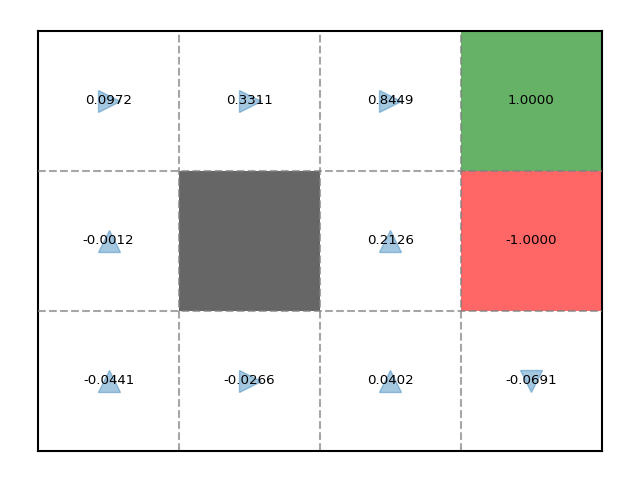

# epoch: 4
eval count = [8, 6, 7, 3]
policy change = [10, 2, 1, 0]


In [ ]:
solver = PolicyIteration(problem, gamma=0.9, debug=True)
solver.train(plot= False)

## Experiment yourself

Now you can try yourself running the Policy Iteration algorithm with a custom map of your choice

# epoch: 5
eval count = [7, 5, 4, 3, 2]
policy change = [18, 9, 3, 1, 0]


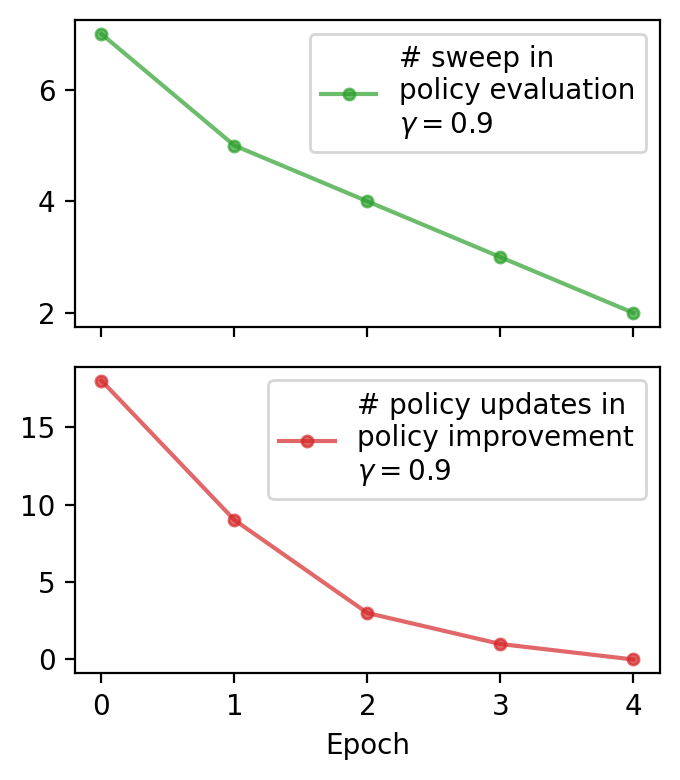

<ipython-input-12-a589d51c2c41>:301: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


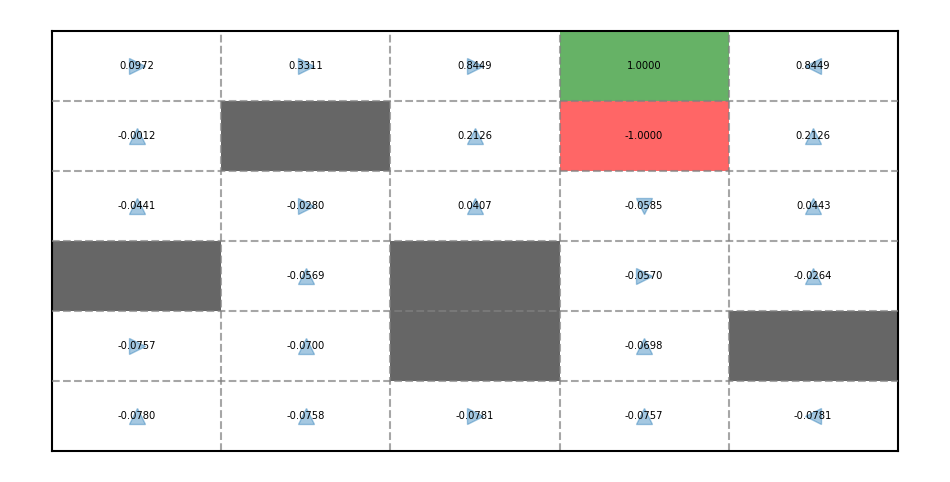

In [ ]:
grid_map = np.array([[0,0,0,1,0],[0,3,0,2,0],[0,0,0,0,0],[3,0,3,0,0],[0,0,3,0,3],[0,0,0,0,0]])

problem = GridWorld(grid_map, reward={0: -0.04, 1: 1.0, 2: -1.0, 3: np.NaN})
solver = PolicyIteration(problem, gamma=0.9, debug=False)
solver.train(plot= True)
problem.visualize_value_policy(policy=solver.policy, values=solver.values, fig_size=(12, 6))


## Loading a Custom Grid World from a CSV File

You can also load a custom Grid map from a CSV file and apply the Policy Iteration algorithm to solve it. This will be useful for very large maps.

The CSV file `world_big.csv` is opened and parsed to create a 2D numpy array, grid_map. Each entry in the CSV file represents a state in the Grid World, and specific values in the map (e.g., rewards, obstacles) define the environment.

**Note**: Before running this cell, make sure to download `world_big.csv` from Blackboard and upload it to your working directory.

# epoch: 501
eval count = [8, 8, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

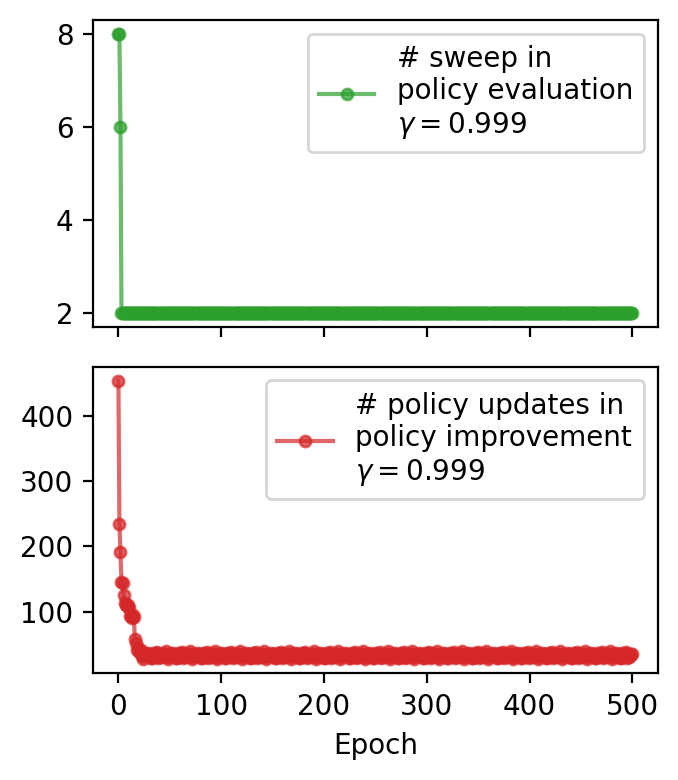

In [ ]:
# For implementation using csv file
file = open('world_big.csv')
grid_map = np.array([list(map(float, s.strip().split(","))) for s in file.readlines()])
file.close()

problem = GridWorld(grid_map, reward={0: -0.04, 1: 1.0, 2: -1.0, 3: np.NaN})
solver = PolicyIteration(problem, gamma=0.999, debug=False)
solver.train(plot= True)
problem.plot_policy(policy=solver.policy, fig_size=(16, 12))
